# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from util import *

# Overview of Synthetic Data Process

ORCID is an amazing service with a crazy-big dataset. However, not all fields partipate fully. This raises the question of whether inconsistencies in ORCID's coverage by field could affect our ability to find trends in the data. 

To that end, we are going to create synthetic data, in which we create counts of men and women moving between fields, whose relative counts will be affected by synthetically generated covariate scores according to a particular effect size. We will then ask whether we can recover that effect using our regression model. 

We will do so in four ways:

1. Can we find the effect if we have all the data?
2. Can we find the effect if we have only 10% of the data?
3. Can we find the effect if we have an *uneven* 10% of the data?
4. Can we find the effect if we have not only an *uneven* 10% of the data, but we also have random gender-biases in who uses ORCID?

Note that here, we will create the synthetic data and analyze the results. However, regressions are done separately, by another collaborator, so that there is no p-hacking involved. Kenny won't know the answers, in other words. He'll just be given paired sets of covariates and field-to-field transition counts. 

# Setup - Flows

First, get a list of existing field names to make file I/O look similar to what Kenny is used to, format-wise.

In [4]:
survey = pd.read_csv('../../data/processed/survey_names.csv')
fields = survey['Discipline'].values

Draw gender ratios for fields from UNIFORM[0.15,0.85]

In [31]:
np.random.seed(4)
field2pf = {}
for field in fields:
    field2pf[field] = np.random.uniform(low=0.15,high=0.85)

Draw covariate values for fields from UNIFORM[2,5]

In [32]:
def draw_covariates(fields):
    field2cov = {}
    for field in fields:
        field2cov[field] = np.random.uniform(low=2,high=5)
    return field2cov

Draw STEM/NON for fields  n=12 STEM


In [33]:
def draw_covariates_STEM(fields):
    field2cov = {}
    field2STEM = {}
    for field in fields:
        field2cov[field] = np.random.uniform(low=2,high=5)
        if field2cov[field] > 4:
            field2STEM[field] = 1
        else:
            field2STEM[field] = 0
    return field2cov,field2STEM

Choose a range of effect sizes: -1 to 1

In [34]:
betas = np.linspace(-1,1,21)

Functions and misc

In [35]:
def get_pij(wi, xi, xj, beta, bias):
    x = beta*(xj-xi) + np.log(wi/(1-wi)) + bias
    return 1/(1+np.exp(-x))

In [36]:
headerstring_transition = 'from_matched_field\tto_matched_field\tn_male\tn_female\n'
headerstring_covariate = 'field\tcovariate\n'
headerstring_covariate_STEM = 'field\tcovariate\tSTEM\n'
answers = []

# Bias Scenario 1: 10X data

In [72]:
np.random.seed(4)
test = 0
uncensored_transitions = 797980
Nbar = uncensored_transitions/(len(fields)*(len(fields)-1))
for beta in betas:
    problem_id = str(np.random.randint(10000000000))
    f = open('synthetic/'+problem_id+'_transitions.tsv','w')
    f.write(headerstring_transition)
    field2cov = draw_covariates(fields)
    g = open('synthetic/'+problem_id+'_covariates.tsv','w')
    g.write(headerstring_covariate)
    for field in fields:
        g.write('{}\t{}\n'.format(field,field2cov[field]))
    g.close()
    answers.append([problem_id,beta,test])
    for origin in fields:
        for destination in fields:
            bias = 0
            Nij = np.random.geometric(p=1/Nbar)
            censoring = 1
            Nij = np.round(censoring*Nij)
            pij = get_pij(field2pf[origin],
                          field2cov[origin],
                          field2cov[destination],
                          beta,
                          bias)
            Wij = np.random.binomial(Nij,pij)
            Mij = Nij - Wij
            
            f.write('{}\t{}\t{}\t{}\n'.format(origin,destination,int(Mij),int(Wij)))
    f.close()

# Bias Scenario 2: 1X data

In [73]:
np.random.seed(4)
test = 1
uncensored_transitions = 797980
Nbar = uncensored_transitions/(len(fields)*(len(fields)-1))
for beta in betas:
    problem_id = str(np.random.randint(10000000000))
    f = open('synthetic/'+problem_id+'_transitions.tsv','w')
    f.write(headerstring_transition)
    field2cov = draw_covariates(fields)
    g = open('synthetic/'+problem_id+'_covariates.tsv','w')
    g.write(headerstring_covariate)
    for field in fields:
        g.write('{}\t{}\n'.format(field,field2cov[field]))
    g.close()
    answers.append([problem_id,beta,test])
    for origin in fields:
        for destination in fields:
            bias = 0
            Nij = np.random.geometric(p=1/Nbar)
            censoring = 0.1
            Nij = np.round(censoring*Nij)
            pij = get_pij(field2pf[origin],
                          field2cov[origin],
                          field2cov[destination],
                          beta,
                          bias)
            Wij = np.random.binomial(Nij,pij)
            Mij = Nij - Wij
            f.write('{}\t{}\t{}\t{}\n'.format(origin,destination,int(Mij),int(Wij)))
    f.close()

# Bias Scenario 3: 1X data, but heterogeneous censoring

In [74]:
np.random.seed(4)
test = 2
uncensored_transitions = 797980
Nbar = uncensored_transitions/(len(fields)*(len(fields)-1))
for beta in betas:
    problem_id = str(np.random.randint(10000000000))
    f = open('synthetic/'+problem_id+'_transitions.tsv','w')
    f.write(headerstring_transition)
    field2cov = draw_covariates(fields)
    g = open('synthetic/'+problem_id+'_covariates.tsv','w')
    g.write(headerstring_covariate)
    for field in fields:
        g.write('{}\t{}\n'.format(field,field2cov[field]))
    g.close()
    answers.append([problem_id,beta,test])
    for origin in fields:
        for destination in fields:
            bias = 0
            Nij = np.random.geometric(p=1/Nbar)
            censoring = np.random.uniform(low=0.0, high=0.2)
            Nij = np.round(censoring*Nij)
            pij = get_pij(field2pf[origin],
                          field2cov[origin],
                          field2cov[destination],
                          beta,
                          bias)
            Wij = np.random.binomial(Nij,pij)
            Mij = Nij - Wij
            f.write('{}\t{}\t{}\t{}\n'.format(origin,destination,int(Mij),int(Wij)))
    f.close()

# Bias Scenario 4: variable bias, 1X data, heterogeneous censoring

In [75]:
np.random.seed(4)
test = 3
uncensored_transitions = 797980
Nbar = uncensored_transitions/(len(fields)*(len(fields)-1))
for rep in range(10):
    for beta in betas:
        problem_id = str(np.random.randint(10000000000))
        f = open('synthetic/'+problem_id+'_transitions.tsv','w')
        f.write(headerstring_transition)
        field2cov = draw_covariates(fields)
        g = open('synthetic/'+problem_id+'_covariates.tsv','w')
        g.write(headerstring_covariate)
        for field in fields:
            g.write('{}\t{}\n'.format(field,field2cov[field]))
        g.close()
        answers.append([problem_id,beta,test])
        for origin in fields:
            for destination in fields:
                bias = np.random.normal(loc=0,scale=1.0)
                Nij = np.random.geometric(p=1/Nbar)
                censoring = np.random.uniform(low=0.0, high=0.2)
                Nij = np.round(censoring*Nij)
                pij = get_pij(field2pf[origin],
                              field2cov[origin],
                              field2cov[destination],
                              beta,
                              bias)
                Wij = np.random.binomial(Nij,pij)
                Mij = Nij - Wij
                f.write('{}\t{}\t{}\t{}\n'.format(origin,destination,int(Mij),int(Wij)))
        f.close()

# Bias Scenario 5: reviewer request

A 2017 study of ORCID adoption (Dasler et al., 2017) found that ORCID usage is much
more prevalent in the sciences and medicine (> 90% of identifiers) as opposed to the
social sciences, arts, and humanities (< 10% of identifiers). People are more likely to sign up for ORCID when in a STEM field. **If people don't populate their ORCID profile with non-science past affiliations, this dataset likely oversamples "downstream" transitions out of science-related fields (vs. upstream).** 

If women are less likely to establish ORCID
profiles (with approximately 38% of identifiers being coded as female in your sample),
could this introduce a systematic bias against detecting upstream transitions by women? It
is unclear from the write-up whether Bias Scenario 4 of the robustness checks addresses
this possibility; if it does, the authors should clarify and elaborate. If it does not, the authors
should address this limitation.


In [76]:
np.random.seed(4)
test = 4
uncensored_transitions = 797980
Nbar = uncensored_transitions/(len(fields)*(len(fields)-1))
for rep in range(10):
    for beta in betas:
        problem_id = str(np.random.randint(10000000000))
        f = open('synthetic/'+problem_id+'_transitions.tsv','w')
        f.write(headerstring_transition)
        field2cov,field2STEM = draw_covariates_STEM(fields)
        g = open('synthetic/'+problem_id+'_covariates.tsv','w')
        g.write(headerstring_covariate)
        for field in fields:
            g.write('{}\t{}\n'.format(field,field2cov[field]))
        g.close()
        answers.append([problem_id,beta,test])
        for origin in fields:
            for destination in fields:
                bias = np.random.normal(loc=0,scale=1.0)
                Nij = np.random.geometric(p=1/Nbar)
                if field2STEM[destination]==1 or field2STEM[origin]==1:
                    censoring = np.random.uniform(low=0.15, high=0.2)
                else:
                    censoring = np.random.uniform(low=0.0, high=0.05)
                Nij = np.round(censoring*Nij)
                pij = get_pij(field2pf[origin],
                              field2cov[origin],
                              field2cov[destination],
                              beta,
                              bias)
                Wij = np.random.binomial(Nij,pij)
                Mij = Nij - Wij
                f.write('{}\t{}\t{}\t{}\n'.format(origin,destination,int(Mij),int(Wij)))
        f.close()

# Save the "answers" for later lookup
Just in case. 

In [77]:
np.save('synthetic/answers.pkl',answers)

# Pass data off to collaborator for blinded experiments

Here, in order to prevent any sort of p-hacking, Larremore sent the files written above (with the lazy random int hash) to Joseph.  Joseph used the methods of the manuscript to estimate an effect size, and saved the results. 

The results are read back in below. 

# Read regression outputs from blinded collaborator

Here we read in the results from Kenny Joseph, collate them by experiment number, and plot them.

In [79]:
kenny = pd.read_csv('synthetic/simchallenge_results_2.csv')
kenny.head()

,filename,beta
0,1035944405,-0.062595
1,1051476786,0.736880
2,1095365104,-0.482680
3,1137865850,-0.805336
4,1142296452,0.308754


Collate results.

In [91]:
results = {}
results[0] = []
results[1] = []
results[2] = []
results[3] = []
results[4] = []
for an in answers:
    prob = an[2]
    correct = an[1]
    submitted = kenny.loc[kenny['filename']==int(an[0]),'beta'].values[0]
    results[prob].append([correct,submitted])

for i in range(5):
    results[i] = np.array(results[i])

Plot

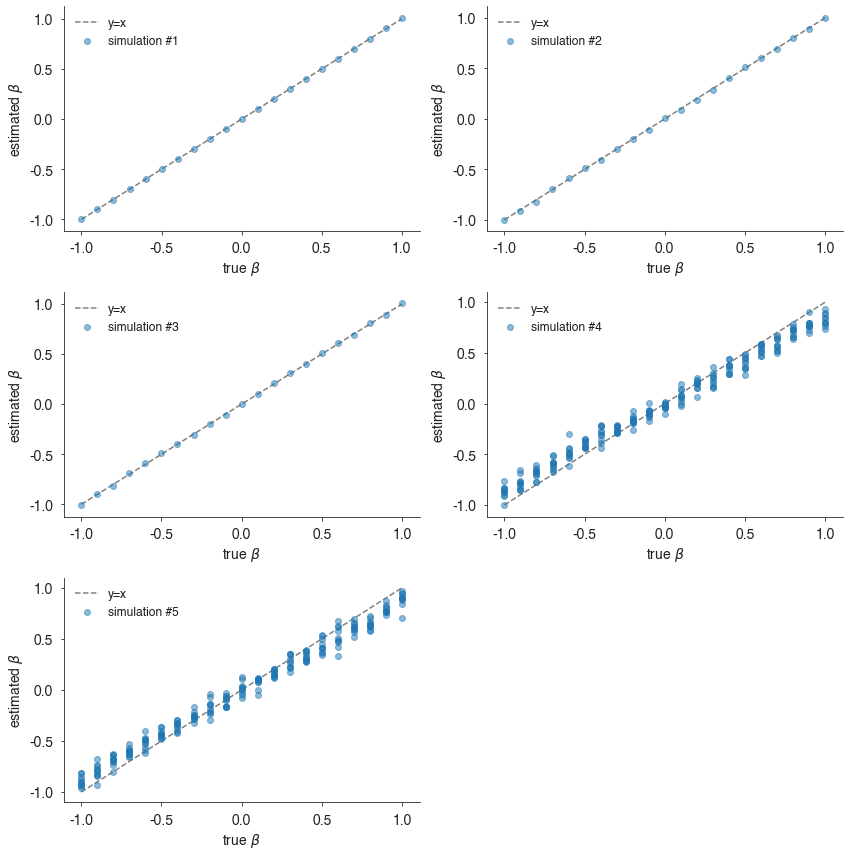

In [96]:
fig,axs = plt.subplots(nrows=3,ncols=2,figsize=(2*6,3*4))
axs = axs.flatten()
for i in range(5):
    ax = axs[i]
    ax.scatter(results[i][:,0],results[i][:,1],
               label='simulation #{}'.format(i+1),zorder=1,alpha=0.5)
    ax.plot([-1,1],[-1,1],'--',color=[0.5,0.5,0.5],zorder=0,label='y=x')
    ax.set_xlabel(r'true $\beta$')
    ax.set_ylabel(r'estimated $\beta$')
    ax.legend(fontsize=12,frameon=False)
    finalize(ax,ignoreLegend=True)
    ax.figure.tight_layout()
axs[5].remove()
plt.savefig('figures/bias_scenario_simulations.pdf')